Modeling SNAIl-qubit module with N qubits. This Hamiltonain follows from:
1. Diagonalizing using Bogoliubov transformation
2. displacement transformation for the drive term
3. Rotating-frame (interaction picture) transformation
   
Note, in our interaction picture, we have the following terms:
- qubit-self, qubit-snail, qubit-qubits
- snail-self, snail-qubits, snail-drive   
4. Eliminate all the qubit non-linearity terms (self-kerr and cross-kerr terms) in order to focus on SNAIL-mediated dynamics. (this leaves us only with snail-self, snail-qubits, snail-drive terms).
This simplification may be revisited later.

The final simplification requires defining the pump frequency $\omega_p = \omega_{q_i} - \omega_{q_j}$.
1. RWA, eliminate fast-rotating terms. Crucially, rather than only keeping the terms that have 0 oscillating phase, we keep terms that have oscillating phase of 0 in the limit of all qubit and SNAIL frequencies being the same (as frequency crowding increases).

We are left with the following terms:
- qubit-qubit-drive (the conventional RWA simplification assuming sufficient frequency spacing only leaves a single qubit-qubit-drive term for the intended interaction).
- qubit-snail-drive
- snail-snail-drive

In [24]:
import numpy as np
from qutip import Options
import qutip as qt
from pathlib import Path
import matplotlib.pyplot as plt
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.hamiltonian import QubitQubitSNAIL
from quantum_logical.pulsesim.mode import QubitMode, CavityMode, SNAILMode

opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
p_bar = qt.ui.TextProgressBar()  # None

In [25]:
qubit1 = QubitMode(name="q1", dim=2, freq=4.004, alpha=-0.1739, T1=1e2, T2=5e1)
qubit2 = QubitMode(name="q2", dim=2, freq=4.16829, alpha=-0.160, T1=1e2, T2=5e1)
# qubit3 = QubitMode(name="q3", dim=2, freq=4.54944, alpha=-0.1275, T1=1e2, T2=5e1)
qubits = [qubit1, qubit2]  # , qubit3]
snail = SNAILMode(name="s", freq=4.27515, g3=0.3, dim=10, T1=1e3, T2=5e2)
_couplings = {
    frozenset([qubit1, snail]): 2 * np.pi * 0.0252,
    frozenset([qubit2, snail]): 2 * np.pi * 0.00993,  # 0.04875,
    # frozenset([qubit3, snail]): 2 * np.pi * 0.0435,
}

qs = QuantumSystem(qubits + [snail], couplings=_couplings)

# get dressed frequencies
qubit_freqs = [qs.dressed_freqs.get(q) for q in qubits]

In [26]:
# create an initial state
psi0 = qs.prepare_tensor_fock_state([(qubit2, 1)])

In [27]:
# define desired unitary and expected final state
# assumes the iSWAP is on qubit1 and qubit2
# U = qt.tensor(
#     qt.qip.operations.iswap(N=2), qt.identity(qubit3.dim), qt.identity(snail.dim)
# )
U = qt.tensor(qt.qip.operations.iswap(N=2))

psi0_rho = qt.ptrace(psi0, [0, 1])
expected_psi = qt.Qobj(U * psi0_rho * U.dag())

In [28]:
expected_psi

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]

In [29]:
# Step 1. construct the (dressed) linear Hamiltonian
H0L = 0
for m in qs.modes:
    H0L += qs.dressed_freqs.get(m) * qs.modes_num[m]

In [30]:
# Step 2. construct the (dressed) non-linear part of the Hamiltonian
# add the SNAIL non-linearity
#  g3 * [s + s^dagger + \sum lambda * (q + q^dagger) ]**3
#
H0Nl = (
    snail.g3 * (sum([qs._lambda(snail, m) * qs.modes_field[m] for m in qs.modes])) ** 3
)

# add the qubit non-linearity terms
# alpha_i/12 * [qi + qi^\dagger + \sum lambda * (qj + qj^\dagger) ]**4
# for q in qubits:
#     H0Nl += (
#         q.alpha
#         / 12
#         * (sum([qs._lambda(q, m) * qs.modes_field[m] for m in qs.modes])) ** 4
#     )

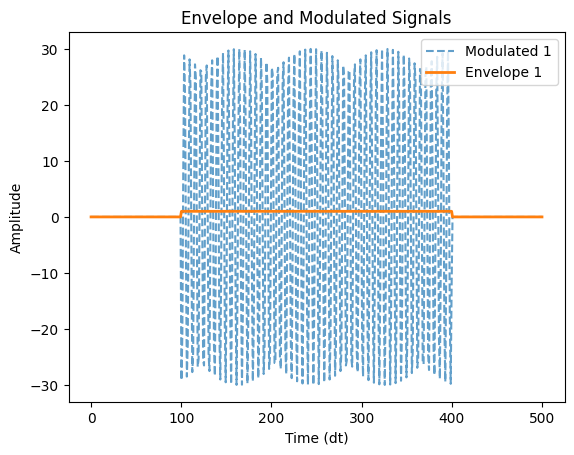

In [38]:
# Step 3. construct the pump term
# Define experiment constants
# define frequency and amplitude ranges
# drive at qubit-qubit conversion with some detuning
width_d = 500
N = 5

detuning_flist = 1000 * np.linspace(-0.01, 0.01, N)  # MHz
flist = 2 * np.pi / 1000 * (detuning_flist) + abs(qubit1.freq - qubit2.freq)
alist = np.linspace(0, 60, N)
args = {
    "shape": Pulse.box,
    "shape_params": {"t0": 100, "width": 300},
}
t_list = np.linspace(0, width_d, 500)

# plot an example pulse from the experiment to verify its shape
omega_p = flist[int(N / 2)]
amp_p = alist[int(N / 2)]
pulse = Pulse(omega=omega_p, amp=amp_p)

# Plot the Gaussian pulse shape
Pulse.plot_pulse([(pulse, args)], t_list)

H_pump = [qs.modes_a_dag[snail] - qs.modes_a[snail], pulse.drive]

In [39]:
# # collapse operators
c_ops = []
# for mode in quantum_system.modes:
#     c_ops.append(mode.collapse_operators(quantum_system))

In [40]:
def simulation_task(freq_amp_tuple):
    freq, amp = freq_amp_tuple
    pulse = Pulse(omega=freq, amp=amp)
    H_pump = [qs.modes_a_dag[snail] - qs.modes_a[snail], pulse.drive]
    H = [H0L, H0Nl, H_pump]

    solve_result = qt.mesolve(H, psi0, t_list, c_ops, args=args, options=opts)
    final_state = solve_result.states[-1]

    # transform this state back to the original basis
    # final_state = qs.transform_to_original_basis(final_state)

    ground_state_populations = [
        qs.mode_population_expectation(final_state, mode, 0) for mode in qs.modes
    ]
    # Calculate fidelity with the expected final state
    final_state = qt.ptrace(final_state, [0, 1])
    fidelity = qt.fidelity(expected_psi, final_state)

    return ground_state_populations, fidelity


# Prepare the parameters for parallel execution
freq_amp_pairs = [(f, a) for f in flist for a in alist]
# Run the simulations in parallel
results = qt.parallel.parallel_map(simulation_task, freq_amp_pairs, progress_bar=True)

12.0%. Run time:  18.57s. Est. time left: 00:00:02:16
20.0%. Run time:  35.44s. Est. time left: 00:00:02:21
32.0%. Run time:  36.94s. Est. time left: 00:00:01:18
40.0%. Run time:  53.11s. Est. time left: 00:00:01:19
52.0%. Run time:  72.08s. Est. time left: 00:00:01:06
60.0%. Run time:  73.36s. Est. time left: 00:00:00:48
72.0%. Run time:  90.52s. Est. time left: 00:00:00:35
80.0%. Run time:  92.50s. Est. time left: 00:00:00:23
92.0%. Run time: 111.40s. Est. time left: 00:00:00:09
100.0%. Run time: 127.38s. Est. time left: 00:00:00:00
Total run time: 127.39s


In [41]:
# Process results
ground_state_populations = np.zeros((len(qs.modes), len(alist), len(flist)))
fidelity_matrix = np.zeros((len(alist), len(flist)))

for idx, (freq, amp) in enumerate(freq_amp_pairs):
    freq_idx = np.where(flist == freq)[0][0]
    amp_idx = np.where(alist == amp)[0][0]
    populations, fidelity = results[idx]

    # Store ground state populations
    for k, pop in enumerate(populations):
        ground_state_populations[k, amp_idx, freq_idx] = pop

    # Store fidelity
    fidelity_matrix[amp_idx, freq_idx] = fidelity

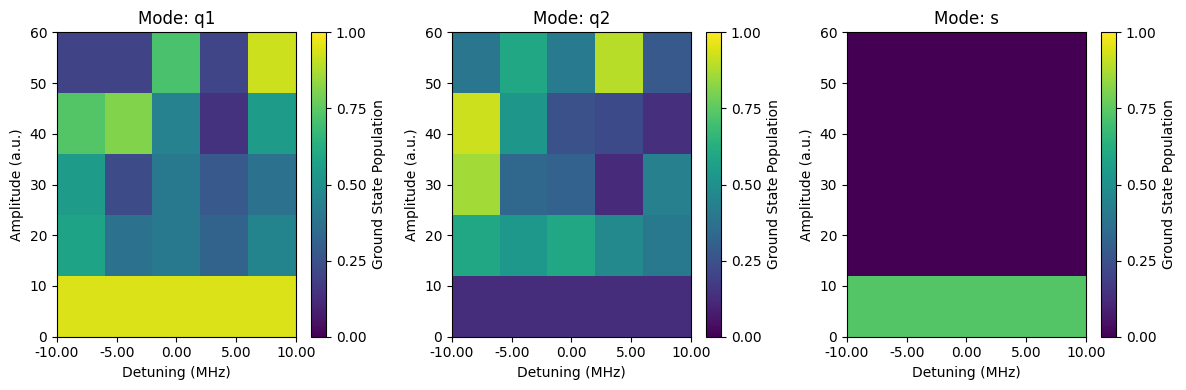

In [42]:
# Prepare the plot
fig, axes = plt.subplots(1, len(qs.modes), figsize=(len(qs.modes) * 4, 4))

# Conversion factor from radian frequency to GHz
rad_to_GHz = 1 / (2 * np.pi)

# Define the number of ticks for the detuning x-axis
n_xticks = 5  # Adjust the number of ticks as needed

# Plot data for each mode
for k, mode in enumerate(qs.modes):
    im = axes[k].imshow(
        ground_state_populations[k],
        # extent=[flist[0] * rad_to_GHz, flist[-1] * rad_to_GHz, alist[0], alist[-1]],
        extent=[detuning_flist[0], detuning_flist[-1], alist[0], alist[-1]],
        aspect="auto",
        origin="lower",
        vmin=0.0,
        vmax=1.0,  # Set color bar scale from 0.0 to 1.0
    )
    axes[k].set_title(f"Mode: {mode.name}")
    # axes[k].set_xlabel("Frequency (GHz)")
    axes[k].set_xlabel("Detuning (MHz)")
    axes[k].set_ylabel("Amplitude (a.u.)")

    # Customize x-axis ticks
    # xticks = np.linspace(flist[0] * rad_to_GHz, flist[-1] * rad_to_GHz, n_xticks)
    xticks = np.linspace(detuning_flist[0], detuning_flist[-1], n_xticks)
    axes[k].set_xticks(xticks)
    axes[k].set_xticklabels([f"{x:.2f}" for x in xticks])  # Format the tick labels

    # Add color bar
    cbar = fig.colorbar(
        im, ax=axes[k], orientation="vertical", label="Ground State Population"
    )
    cbar.set_ticks(np.linspace(0, 1, 5))  # Customize color bar ticks

plt.tight_layout()
plt.show()

In [43]:
# Find the pulse parameters that maximize fidelity
max_fidelity = np.max(fidelity_matrix)
max_fidelity_indices = np.where(fidelity_matrix == max_fidelity)

# Since the indices are returned in a tuple of arrays, we take the first element
max_fidelity_amp_idx, max_fidelity_freq_idx = (
    max_fidelity_indices[0][0],
    max_fidelity_indices[1][0],
)

# Retrieve the amplitude and width that correspond to the maximum fidelity
max_fidelity_freq = flist[max_fidelity_freq_idx]
max_fidelity_amp = alist[max_fidelity_amp_idx]

print(f"Max fidelity: {max_fidelity:.4f}")
print(f"Pulse freq for max fidelity: {max_fidelity_freq:.2f} GHz")
print(f"Pulse amplitude for max fidelity: {max_fidelity_amp:.2f} a.u.")

Max fidelity: 0.8671
Pulse freq for max fidelity: 1.06 GHz
Pulse amplitude for max fidelity: 60.00 a.u.


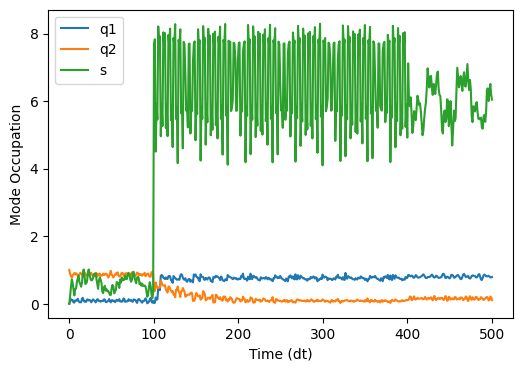

In [44]:
# max_fidelity_freq = abs(qs.dressed_freqs.get(qubit1) - qs.dressed_freqs.get(qubit2))
pulse = Pulse(omega=max_fidelity_freq, amp=max_fidelity_amp)
H_pump = [qs.modes_a_dag[snail] - qs.modes_a[snail], pulse.drive]
H = [H0L, H0Nl, H_pump]

e_ops = [qs.modes_num[m] for m in qs.modes]
solve_result = qt.mesolve(H, psi0, t_list, args=args, options=opts, e_ops=e_ops)

# Plot the state evolution (<n> vs time) for each mode (one plot total)
fig, ax = plt.subplots(figsize=(6, 4))
for k, mode in enumerate(qs.modes):
    ax.plot(t_list, solve_result.expect[k], label=mode.name)
ax.set_xlabel("Time (dt)")
ax.set_ylabel("Mode Occupation")
ax.legend()
plt.show()